In [1]:
############# Import libraries #############
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from matplotlib import pyplot as plt

%matplotlib inline

from keras.layers import Input, Dropout, Dense, add
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import TensorBoard
# from gcn.gae import *
from keras_gcn.kegra.utils import *
from keras_gcn.kegra import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph

from gcnae_ad.layers import *

import time
import math

Using TensorFlow backend.


In [2]:
############# Read the graph, features and labels file #############
# graph = nx.read_graphml('./Disney/Disney.graphml')
# labels_df = pd.read_csv('./Disney/Disney.true', sep=';', header=None)

# Load data for 2 views
data_1 = loadmat("PIE{}.mat".format('09'))
data_2 = loadmat("PIE{}.mat".format('27'))

# Get ground truth of each view
labels_1 = data_1['gnd'] - 1
labels_2 = data_2['gnd'] - 1

# Get features of each view
feat_1 = data_1['fea']
feat_2 = data_2['fea']

num_labels = len(np.unique(labels_2))

# Feat 2 consists of 49 samples/face. Select only 24/face randomly.
samples_idx = np.arange(feat_2.shape[0], dtype='int32')
idx_select = []
for i in range(num_labels):
    idx_label = samples_idx[i*49:(i*49)+24]
    idx_select = idx_select + list(idx_label)

feat_2 = feat_2[idx_select, :]
labels_2 = labels_2[idx_select]

num_samples = feat_2.shape[0]
num_samples_label = int(num_samples/num_labels)
num_feat = feat_2.shape[1]

print('Number of samples: {}'.format(num_samples))
print('Number of ground truth labels: {}'.format(num_labels))
print('Number of samples per label: {}'.format(num_samples_label))
print('Number of features: {}'.format(num_feat))

Number of samples: 1632
Number of ground truth labels: 68
Number of samples per label: 24
Number of features: 1024


In [3]:
# Fix Total number of outliers
frac_outliers = 0.05
num_outliers = int(frac_outliers * num_samples)
num_outliers_1 = int(num_outliers/1.5)
num_outliers_2 = num_outliers - num_outliers_1

print('Total number of outliers: {}'.format(num_outliers))
print('Number of Type-I outliers: {}'.format(num_outliers_1))
print('Number of Type-II outliers: {}'.format(num_outliers_2))

Total number of outliers: 81
Number of Type-I outliers: 54
Number of Type-II outliers: 27


In [4]:
# Create Type-1 anomalies
# TAke 2 samples of 2 different classes, swap features in only one view
rand_labels = np.random.choice(np.arange(num_labels), 
                               num_outliers_1, 
                               replace=False)
rand_sample_idx_1 = rand_labels * num_samples_label
rand_feat_1 = feat_1[rand_sample_idx_1]

i = 0
while i < num_outliers_1:
    row_1, row_2 = rand_sample_idx_1[i:i+2]
    feat_1[[row_1, row_2]] = feat_1[[row_2, row_1]]  
    i = i + 2

# Create Type-2 anomalies
# Select m samples and assign random features in both views
keep_trying = True
while keep_trying:
    rand_sample_idx_2 = np.random.choice(np.arange(feat_1.shape[0]), 
                               num_outliers_2, 
                               replace=False)
    rand_sample_int = set(rand_sample_idx_1).intersection(set(rand_sample_idx_2))

    if len(rand_sample_int) == 0:
        keep_trying = False

for idx in rand_sample_idx_2:
    feat_1[idx] = np.random.random_sample((1, num_feat))
    feat_2[idx] = np.random.random_sample((1, num_feat))

In [5]:
# Normalize each view features
# X_1 = feat_1/feat_1.sum(1).reshape(-1, 1)
# X_2 = feat_2/feat_2.sum(1).reshape(-1, 1)
X_1 = feat_1
X_2 = feat_2

# Create k-NN graph for each view
A_1 = kneighbors_graph(X_1, 5, metric='minkowski', 
                       mode='connectivity', include_self=True, 
                       n_jobs=-1)
A_2 = kneighbors_graph(X_2, 5, metric='minkowski', 
                       mode='connectivity', include_self=True, 
                       n_jobs=-1)

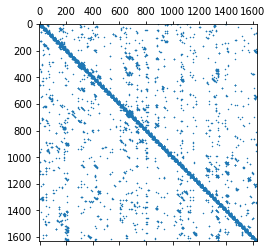

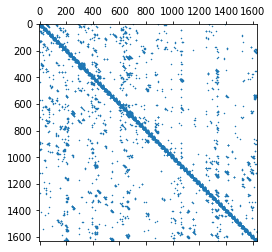

In [6]:
plt.spy(A_1, markersize=0.5)
plt.show()
plt.spy(A_2, markersize=0.5)

In [7]:
############# Explore graph data #############
num_nodes = A_1.shape[0]
num_edges = A_1.nnz
print('Number of nodes: {}'.format(num_nodes))
print('Number of edges: {}'.format(num_edges))

Number of nodes: 1632
Number of edges: 8160


In [8]:
############# Labels (0/1) for the dataset #############
labels_binary = np.zeros((num_nodes, ), dtype='int32')
samples_idx = np.arange(num_samples, dtype='int32')

anom_idx = np.concatenate((rand_sample_idx_1, 
                          rand_sample_idx_2))

labels_binary[anom_idx] = 1

print(np.unique(labels_binary, return_counts=True))

normal = samples_idx[labels_binary == 0]
anom = samples_idx[labels_binary == 1]

print(len(normal), len(anom))

(array([0, 1], dtype=int32), array([1551,   81]))
1551 81


In [9]:
############# Get train and test indices #############
idx_train, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, 
                                                random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, 
                                                   test_size=.8, random_state=42)
anormal_valid_1, anormal_test_1, _, _ = train_test_split(rand_sample_idx_1, 
                                                         rand_sample_idx_1, 
                                                         test_size=.8, 
                                                         random_state=42)
anormal_valid_2, anormal_test_2, _, _ = train_test_split(rand_sample_idx_2, 
                                                         rand_sample_idx_2, 
                                                         test_size=.8, 
                                                         random_state=42)

anormal_valid = np.concatenate((anormal_valid_1, anormal_valid_2))
anormal_test = np.concatenate((anormal_test_1, anormal_test_2))

idx_val = np.concatenate((normal_valid, anormal_valid))
idx_test = np.concatenate((normal_test, anormal_test))
idx_val = np.random.choice(idx_val, len(idx_val), replace=False)
idx_test = np.random.choice(idx_test, len(idx_test), replace=False)

print('Train shape: ', idx_train.shape)
print('Number of anomaly in training set: %.2f' % 0)
print('Valid shape: ', idx_val.shape)
print('Number of anomaly in validation set: %.2f' % len(anormal_valid))
print('Test shape:, ', idx_test.shape)
print('Number of anomaly in test set: %.2f' % len(anormal_test))

Train shape:  (1240,)
Number of anomaly in training set: 0.00
Valid shape:  (77,)
Number of anomaly in validation set: 15.00
Test shape:,  (315,)
Number of anomaly in test set: 66.00


In [10]:
############# Prepare data for GCN #############
y_onehot = encode_onehot(labels_binary)

y_train = np.zeros(y_onehot.shape, dtype='int32')
y_val = np.zeros(y_onehot.shape, dtype='int32')
y_test = np.zeros(y_onehot.shape, dtype='int32')

y_train[idx_train] = y_onehot[idx_train]
y_val[idx_val] = y_onehot[idx_val]
y_test[idx_test] = y_onehot[idx_test]

train_mask = sample_mask(idx_train, y_onehot.shape[0])
val_mask = sample_mask(idx_val, y_onehot.shape[0])
test_mask = sample_mask(idx_test, y_onehot.shape[0])

In [11]:
# ############# Equally split features into 2 views #############
# X_df_1, X_df_2 = np.split(X_df, [int(num_feat/2)], axis=1)
# print('Features in view 1: ', X_df_1.columns.values)
# print('Features in view 2: ', X_df_2.columns.values)

# # Normalize
# X_1 = X_df_1.values/X_df_1.values.sum(1).reshape(-1, 1)
# X_2 = X_df_2.values/X_df_2.values.sum(1).reshape(-1, 1)

In [12]:
############# Define hyperparameters #############
MAX_DEGREE = 2  # maximum polynomial degree
SYM_NORM = True  # symmetric (True) vs. left-only (False) normalization
NB_EPOCH = 200
PATIENCE = 10  # early stopping patience

In [13]:
############# Preprocess and package data #############
# build symmetric adjacency matrix
adj_sym_1 = A_1 + A_1.T.multiply(A_1.T > A_1) - A_1.multiply(A_1.T > A_1)
adj_sym_2 = A_2 + A_2.T.multiply(A_2.T > A_2) - A_2.multiply(A_2.T > A_2)

A_prep_1 = preprocess_adj(adj_sym_1, SYM_NORM)
A_prep_2 = preprocess_adj(adj_sym_2, SYM_NORM)

support = 1
g_1 = [X_1, A_prep_1]
g_2 = [X_2, A_prep_2]

In [14]:
############# Autoencoder architecture #############
# num of hidden units
encoded_dim_0 = 512
encoded_dim_1 = int(encoded_dim_0/4)

# Input Layers
G_1 = [Input(shape=(None, None), batch_shape=(None, None), sparse=True)]
G_2 = [Input(shape=(None, None), batch_shape=(None, None), sparse=True)]
X_in_1 = Input(shape=(X_1.shape[1],))
X_in_2 = Input(shape=(X_2.shape[1],))

# Encoder View 1
encoded_1 = GraphConvolution(encoded_dim_0, support, activation='relu', 
                           kernel_regularizer=l2(5e-4), name='enc_10')([X_in_1]+G_1)
encoded_1 = Dropout(0.5)(encoded_1)
encoded_1 = GraphConvolution(encoded_dim_1, support, activation='relu', 
                           kernel_regularizer=l2(5e-4), name='enc_11')([encoded_1]+G_1)

encoder_model_1 = Model([X_in_1]+G_1, encoded_1)
encoded_10_layer = encoder_model_1.get_layer('enc_10')
encoded_11_layer = encoder_model_1.get_layer('enc_11')

# Encoder View 2
encoded_2 = GraphConvolution(encoded_dim_0, support, activation='relu', 
                           kernel_regularizer=l2(5e-4), name='enc_20')([X_in_2]+G_2)
encoded_2 = Dropout(0.5)(encoded_2)
encoded_2 = GraphConvolution(encoded_dim_1, support, activation='relu', 
                           kernel_regularizer=l2(5e-4), name='enc_21')([encoded_2]+G_2)

encoder_model_2 = Model([X_in_2]+G_2, encoded_2)
encoded_20_layer = encoder_model_2.get_layer('enc_20')
encoded_21_layer = encoder_model_2.get_layer('enc_21')

In [15]:
# Fusion layer
# encoded_merged = maximum([encoded_1, encoded_2], name='merge_max')
# encoded_merged = average([encoded_1, encoded_2], name='merge_avg')

# View Alignment layer
valign = Alignment(reg_weight=0.3, name='view_align')([encoded_1, encoded_2])

In [16]:
# Decoder (Features) View 1
decoded_X_1 = DenseTied(encoded_dim_0, tie_to=encoded_11_layer, transpose=True,
            activation='relu', name='dec_X_11')(encoded_1)
decoded_X_1 = DenseTied(X_1.shape[1], tie_to=encoded_10_layer, transpose=True,
            activation='linear', name='dec_X_10')(decoded_X_1)

# Decoder View 2
decoded_X_2 = DenseTied(encoded_dim_0, tie_to=encoded_21_layer, transpose=True,
            activation='relu', name='dec_X_21')(encoded_2)
decoded_X_2 = DenseTied(X_2.shape[1], tie_to=encoded_20_layer, transpose=True,
            activation='linear', name='dec_X_20')(decoded_X_2)


# Decoder adjacency
# decoded_adj_1 = Decoder(adj.shape[1], activation='linear', name='dec_adj_1')(encoded_merged)

In [17]:
############# Initialize model #############
autoenc_model = Model(inputs=[X_in_1]+G_1+[X_in_2]+G_2, 
                      outputs=[decoded_X_1, decoded_X_2, valign])

In [18]:
############# Compile model #############
autoenc_model.compile(loss={'dec_X_10': 'mean_squared_error',
                            'dec_X_20': 'mean_squared_error', 
                            'view_align': zero_loss},
                      optimizer=Adam(lr=0.001))

autoenc_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
enc_10 (Gr

In [19]:
############# Run model #############
wait = 0
preds = None
best_val_loss = 99999
train_losses = list()
val_losses = list()

# Fit
for epoch in range(1, NB_EPOCH+1):

    # Log wall-clock time
    t = time.time()

    # Single training iteration (we mask nodes without labels for loss calculation)
    autoenc_model.fit(g_1 + g_2, 
                      [X_1, X_2, np.zeros((num_samples, 1))],
                      sample_weight=[train_mask, train_mask, train_mask],
                      batch_size=num_samples, 
                      epochs=1, shuffle=False, verbose=0)

    # Predict on full dataset
    preds_X_1, preds_X_2, view_loss = autoenc_model.predict(g_1 + g_2, 
                                                            batch_size=num_samples)
    
    # Train / validation loss, accuracy
    # View 1
    train_loss_1 = mean_squared_error(preds_X_1[idx_train], X_1[idx_train])
    val_loss_1 = mean_squared_error(preds_X_1[idx_val], X_1[idx_val])
    # View 2
    train_loss_2 = mean_squared_error(preds_X_2[idx_train], X_2[idx_train])
    val_loss_2 = mean_squared_error(preds_X_2[idx_val], X_2[idx_val])
    # View align loss
    train_loss_3 = np.mean(view_loss[idx_train])
    val_loss_3 = np.mean(view_loss[idx_val])
    # Total val loss
    val_loss = val_loss_1 + val_loss_2 + val_loss_3
    
    train_losses.append([train_loss_1, train_loss_2, train_loss_3])
    val_losses.append([val_loss_1, val_loss_2, val_loss_3])

    print('Epoch: {:04d}'.format(epoch),
#           'train_loss_1= {:.4f}'.format(train_loss_1),
#           'val_loss_1= {:.4f}'.format(val_loss_1),
#           'train_loss_2= {:.4f}'.format(train_loss_2),
#           'val_loss_2= {:.4f}'.format(val_loss_2),
#           'train_loss_3= {:.4f}'.format(train_loss_3),
#           'val_loss_3= {:.4f}'.format(val_loss_3),
          'time= {:.4f}'.format(time.time() - t))

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
    else:
        if wait >= PATIENCE:
            print('Epoch {}: early stopping'.format(epoch))
            break
        wait += 1

Epoch: 0001 time= 1.8106
Epoch: 0002 time= 0.1101
Epoch: 0003 time= 0.1093
Epoch: 0004 time= 0.1089
Epoch: 0005 time= 0.1079
Epoch: 0006 time= 0.1101
Epoch: 0007 time= 0.1087
Epoch: 0008 time= 0.1114
Epoch: 0009 time= 0.1099
Epoch: 0010 time= 0.1077
Epoch: 0011 time= 0.1094
Epoch: 0012 time= 0.1075
Epoch: 0013 time= 0.1091
Epoch: 0014 time= 0.1072
Epoch: 0015 time= 0.1088
Epoch: 0016 time= 0.1075
Epoch: 0017 time= 0.1103
Epoch: 0018 time= 0.1075
Epoch: 0019 time= 0.1080
Epoch: 0020 time= 0.1049
Epoch: 0021 time= 0.1077
Epoch: 0022 time= 0.1073
Epoch: 0023 time= 0.1081
Epoch: 0024 time= 0.1074
Epoch: 0025 time= 0.1071
Epoch: 0026 time= 0.1087
Epoch: 0027 time= 0.1099
Epoch: 0028 time= 0.1065
Epoch: 0029 time= 0.1079
Epoch: 0030 time= 0.1048
Epoch: 0031 time= 0.1092
Epoch: 0032 time= 0.1079
Epoch: 0033 time= 0.1100
Epoch: 0034 time= 0.1078
Epoch: 0035 time= 0.1083
Epoch: 0036 time= 0.1074
Epoch: 0037 time= 0.1087
Epoch: 0038 time= 0.1059
Epoch: 0039 time= 0.1081
Epoch: 0040 time= 0.1067


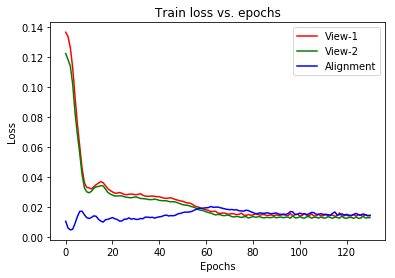

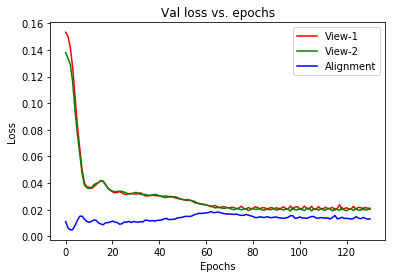

In [20]:
# Plot train and val loss vs epochs
train_losses = np.array(train_losses)
epoch_idx = np.arange(epoch, dtype='int32')
plt.plot(epoch_idx, train_losses[:, 0], 
        color='red', label='View-1')
plt.plot(epoch_idx, train_losses[:, 1], 
        color='green', label='View-2')
plt.plot(epoch_idx, train_losses[:, 2], 
        color='blue', label='Alignment')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss vs. epochs')
plt.legend()
plt.show()

val_losses = np.array(val_losses)
epoch_idx = np.arange(epoch, dtype='int32')
plt.plot(epoch_idx, val_losses[:, 0], 
        color='red', label='View-1')
plt.plot(epoch_idx, val_losses[:, 1], 
        color='green', label='View-2')
plt.plot(epoch_idx, val_losses[:, 2], 
        color='blue', label='Alignment')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Val loss vs. epochs')
plt.legend()
plt.show()

In [21]:
# Testing
test_loss_1 = mean_squared_error(preds_X_1[idx_test], X_1[idx_test])
test_loss_2 = mean_squared_error(preds_X_2[idx_test], X_2[idx_test])
test_loss_3 = np.mean(view_loss[idx_test])

print("Test set results:",
      "loss 1 = {:.4f}".format(test_loss_1),
      "loss 2 = {:.4f}".format(test_loss_2),
      "loss 3 = {:.4f}".format(test_loss_3),
     )

Test set results: loss 1 = 0.0218 loss 2 = 0.0220 loss 3 = 0.0114


In [22]:
############# Compute Intra-view anomaly score #############
# Use norm of reconstruction error of each sample (row) as anomaly score
res_1 = X_1 - preds_X_1
res_2 = X_2 - preds_X_2
pred_norms_1 = np.linalg.norm(res_1, axis=1)
pred_norms_2 = np.linalg.norm(res_2, axis=1)

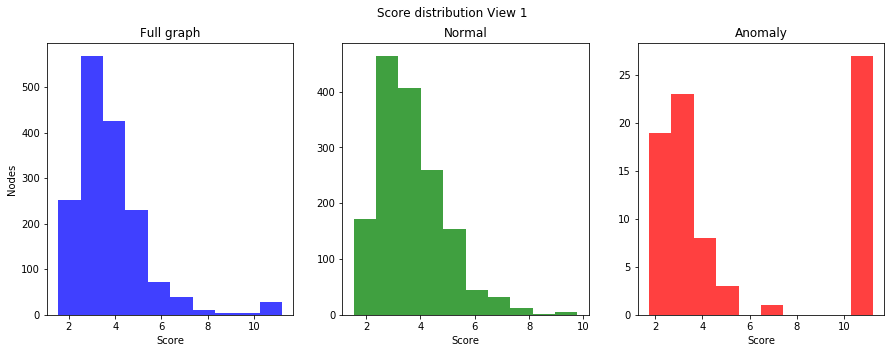

In [23]:
# Histogram of score distribution View 1
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].hist(pred_norms_1, 10, facecolor='b', alpha=0.75)
axes[1].hist(pred_norms_1[normal], 10, facecolor='g', alpha=0.75)
axes[2].hist(pred_norms_1[anom], 10, facecolor='r', alpha=0.75)

axes[0].set_xlabel('Score')
axes[1].set_xlabel('Score')
axes[2].set_xlabel('Score')
axes[0].set_ylabel('Nodes')
axes[0].set_title('Full graph')
axes[1].set_title('Normal')
axes[2].set_title('Anomaly')
fig.suptitle('Score distribution View 1')
plt.show()

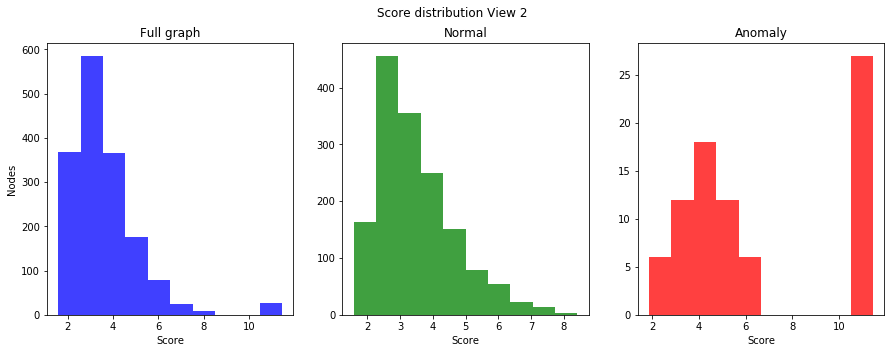

In [24]:
# Histogram of score distribution View 2
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].hist(pred_norms_2, 10, facecolor='b', alpha=0.75)
axes[1].hist(pred_norms_2[normal], 10, facecolor='g', alpha=0.75)
axes[2].hist(pred_norms_2[anom], 10, facecolor='r', alpha=0.75)

axes[0].set_xlabel('Score')
axes[1].set_xlabel('Score')
axes[2].set_xlabel('Score')
axes[0].set_ylabel('Nodes')
axes[0].set_title('Full graph')
axes[1].set_title('Normal')
axes[2].set_title('Anomaly')
fig.suptitle('Score distribution View 2')
plt.show()

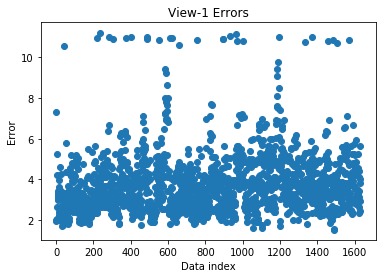

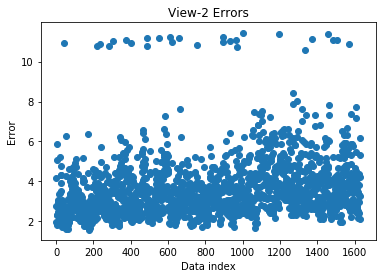

In [25]:
# Scatter plot of intra-view errors
plt.scatter(samples_idx, pred_norms_1)
plt.xlabel('Data index')
plt.ylabel('Error')
plt.title('View-1 Errors')
plt.show()

plt.scatter(samples_idx, pred_norms_2)
plt.xlabel('Data index')
plt.ylabel('Error')
plt.title('View-2 Errors')
plt.show()

In [26]:
############# Compute intra-view AUC #############
auc_1_val = roc_auc_score(labels_binary[idx_val], pred_norms_1[idx_val])
print('View-1 AUC for val data: {:.4f}'.format(auc_1_val))
auc_1_test = roc_auc_score(labels_binary[idx_test], pred_norms_1[idx_test])
print('View-1 AUC for test data: {:.4f}'.format(auc_1_test))
auc_1 = roc_auc_score(labels_binary, pred_norms_1)
print('View-1 AUC for all data: {:.4f}\n'.format(auc_1))

auc_2_val = roc_auc_score(labels_binary[idx_val], pred_norms_2[idx_val])
print('View-2 AUC for val data: {:.4f}'.format(auc_2_val))
auc_2_test = roc_auc_score(labels_binary[idx_test], pred_norms_2[idx_test])
print('View-2 AUC for test data: {:.4f}'.format(auc_2_test))
auc_2 = roc_auc_score(labels_binary, pred_norms_2)
print('View-2 AUC for all data: {:.4f}'.format(auc_2))

View-1 AUC for val data: 0.5054
View-1 AUC for test data: 0.6001
View-1 AUC for all data: 0.5851

View-2 AUC for val data: 0.7785
View-2 AUC for test data: 0.7839
View-2 AUC for all data: 0.7981


In [27]:
############# Compute embedding for view 1 and 2 #############
z_1 = encoder_model_1.predict(g_1, batch_size=num_samples)
z_2 = encoder_model_2.predict(g_2, batch_size=num_samples)

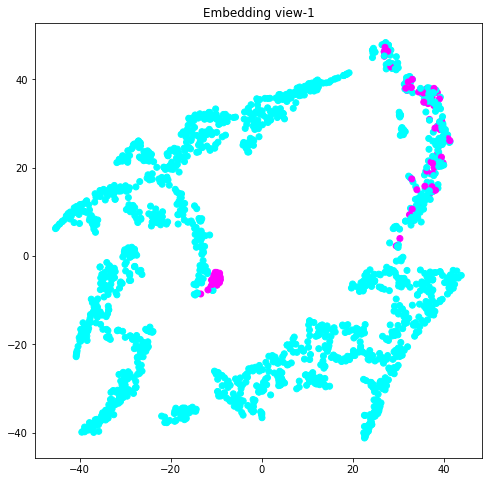

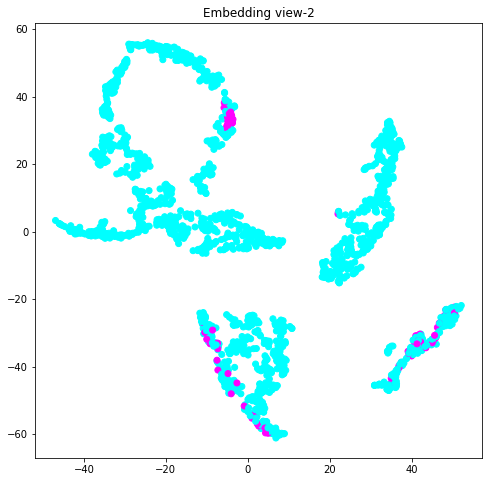

In [28]:
adj_embedded_1 = TSNE(n_components=2).fit_transform(z_1)
plt.figure(figsize=(8, 8))
plt.scatter(adj_embedded_1[:, 0], adj_embedded_1[: ,1], 
            c=labels_binary, cmap=plt.cm.get_cmap("cool", 2))
plt.title('Embedding view-1')
plt.show()

adj_embedded_2 = TSNE(n_components=2).fit_transform(z_2)
plt.figure(figsize=(8, 8))
plt.scatter(adj_embedded_2[:, 0], adj_embedded_2[: ,1], 
            c=labels_binary, cmap=plt.cm.get_cmap("cool", 2))
plt.title('Embedding view-2')
plt.show()

In [29]:
############# Compute outer products #############
z1z2 = np.dot(z_1, np.transpose(z_2))
res1res2 = np.dot(res_1, np.transpose(res_2))

In [30]:
# Compute type-I scores
type_1_scores = list()
labels_1_dup = np.reshape(labels_1, (-1,))

for i in range(num_samples):
    class_i = labels_1_dup[i]
    class_idx = samples_idx[labels_1_dup == class_i]
    type_1_scores.append(np.sum(z1z2[i, class_idx]))

type_1_scores = np.array(type_1_scores)

# Compute type-2 scores
type_2_scores = np.absolute(np.sum(res1res2, axis=1))

# Compute cross-view anomaly score
gamma = 1.0
cross_scores = type_1_scores - (type_2_scores * gamma)

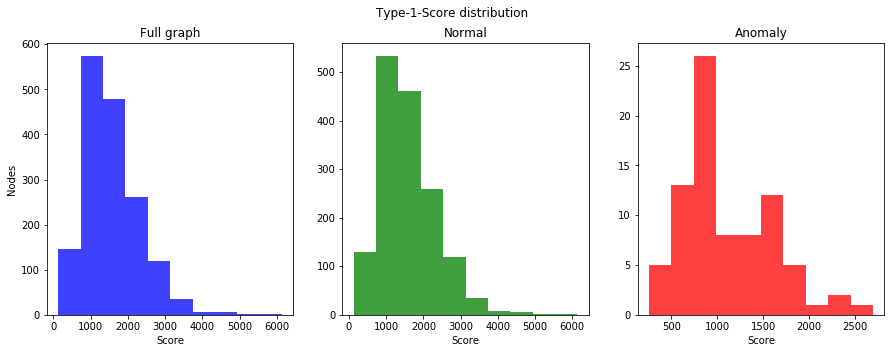

In [31]:
# Histogram of type-1-score distribution
# Lower the score, higher the chance of anomaly
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].hist(type_1_scores, 10, facecolor='b', alpha=0.75)
axes[1].hist(type_1_scores[normal], 10, facecolor='g', alpha=0.75)
axes[2].hist(type_1_scores[anom], 10, facecolor='r', alpha=0.75)

axes[0].set_xlabel('Score')
axes[1].set_xlabel('Score')
axes[2].set_xlabel('Score')
axes[0].set_ylabel('Nodes')
axes[0].set_title('Full graph')
axes[1].set_title('Normal')
axes[2].set_title('Anomaly')
fig.suptitle('Type-1-Score distribution')
plt.show()

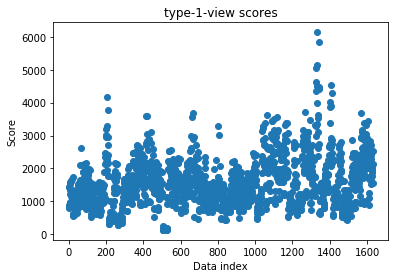

In [32]:
# Scatter plot of type-1 scores
plt.scatter(samples_idx, type_1_scores)
plt.xlabel('Data index')
plt.ylabel('Score')
plt.title('type-1-view scores')
plt.show()

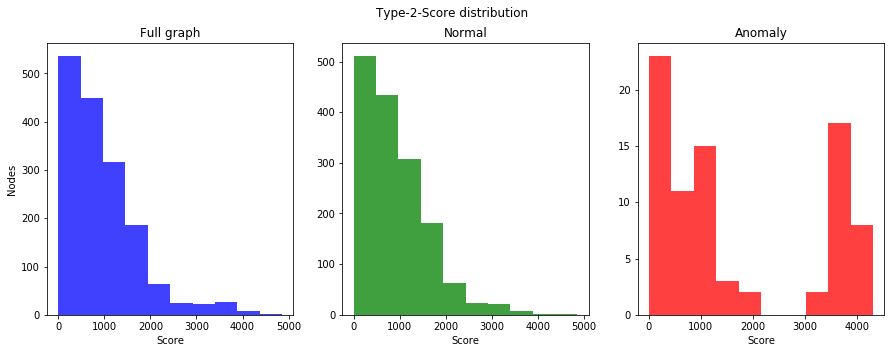

In [33]:
# Histogram of type-2-score distribution
# Higher the score, higher the chance of anomaly
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].hist(type_2_scores, 10, facecolor='b', alpha=0.75)
axes[1].hist(type_2_scores[normal], 10, facecolor='g', alpha=0.75)
axes[2].hist(type_2_scores[anom], 10, facecolor='r', alpha=0.75)

axes[0].set_xlabel('Score')
axes[1].set_xlabel('Score')
axes[2].set_xlabel('Score')
axes[0].set_ylabel('Nodes')
axes[0].set_title('Full graph')
axes[1].set_title('Normal')
axes[2].set_title('Anomaly')
fig.suptitle('Type-2-Score distribution')
plt.show()

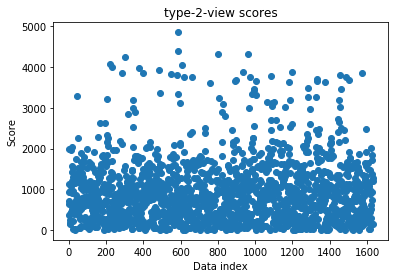

In [34]:
# Scatter plot of type-2 scores
plt.scatter(samples_idx, type_2_scores)
plt.xlabel('Data index')
plt.ylabel('Score')
plt.title('type-2-view scores')
plt.show()

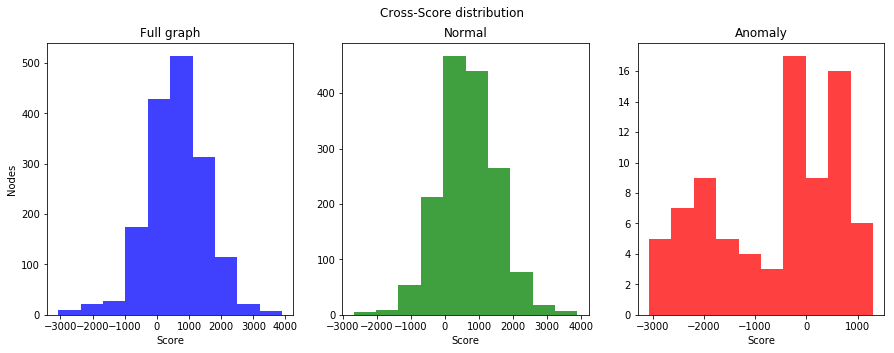

In [35]:
# Histogram of cross-score distribution
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].hist(cross_scores, 10, facecolor='b', alpha=0.75)
axes[1].hist(cross_scores[normal], 10, facecolor='g', alpha=0.75)
axes[2].hist(cross_scores[anom], 10, facecolor='r', alpha=0.75)

axes[0].set_xlabel('Score')
axes[1].set_xlabel('Score')
axes[2].set_xlabel('Score')
axes[0].set_ylabel('Nodes')
axes[0].set_title('Full graph')
axes[1].set_title('Normal')
axes[2].set_title('Anomaly')
fig.suptitle('Cross-Score distribution')
plt.show()

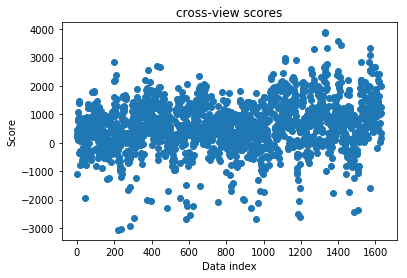

In [36]:
# Scatter plot of cross view scores
plt.scatter(samples_idx, cross_scores)
plt.xlabel('Data index')
plt.ylabel('Score')
plt.title('cross-view scores')
plt.show()

In [37]:
# Generate binary label vectors and find AUC
thresh = np.linspace(np.min(cross_scores), 
                    np.max(cross_scores),
                    1000)
thresh_best = 0
auc_best = 0
thresh_val_best = 0
auc_val_best = 0
thresh_test_best = 0
auc_test_best = 0
for i in thresh:
    pred_labels = np.zeros(num_samples, dtype='int32')
    pred_anom_idx = (cross_scores < i)
    pred_labels[pred_anom_idx] = 1
    pred_auc = roc_auc_score(labels_binary, pred_labels)
    
    if pred_auc > auc_best:
        auc_best = pred_auc
        thresh_best = i
    
    pred_val_labels = np.zeros(num_samples, dtype='int32')[idx_val]
    pred_anom_val_idx = (cross_scores[idx_val] < i)
    pred_val_labels[pred_anom_val_idx] = 1
    pred_val_auc = roc_auc_score(labels_binary[idx_val], pred_val_labels)
    
    if pred_val_auc > auc_val_best:
        auc_val_best = pred_val_auc
        thresh_val_best = i
    
    pred_test_labels = np.zeros(num_samples, dtype='int32')[idx_test]
    pred_anom_test_idx = (cross_scores[idx_test] < i)
    pred_test_labels[pred_anom_test_idx] = 1
    pred_test_auc = roc_auc_score(labels_binary[idx_test], pred_test_labels)
    
    if pred_test_auc > auc_test_best:
        auc_test_best = pred_test_auc
        thresh_test_best = i

print('Best AUC for all data: {:.4f}, Thresh: {:.4f}'.format(auc_best, thresh_best))
print('Best AUC for val data: {:.4f}, Thresh: {:.4f}'.format(auc_val_best, thresh_val_best))
print('Best AUC for test data: {:.4f}, Thresh: {:.4f}'.format(auc_test_best, thresh_test_best))

Best AUC for all data: 0.7175, Thresh: 26.2217
Best AUC for val data: 0.7102, Thresh: -419.7769
Best AUC for test data: 0.7269, Thresh: 26.2217
